In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy
import pandas

import pickle
def fnSaveObject(save_object, sFileName):
    with open(sFileName, "wb") as file:
        pickle.dump(save_object, file)

def fnLoadObject(sFileName):
    with open(sFileName, 'rb') as file:
        load_object = pickle.load(file)
    return load_object

sans_models = ['sphere', 'core_shell_sphere', 'ellipsoid', 'core_shell_ellipsoid', 'cylinder', 'core_shell_cylinder', 'three_pearl_necklace', 'lamellar', 'lamellar_hg']
data_x_pandas = []
data_y_pandas = []
ydim=[]
for sansmodel in sans_models:
    print(sansmodel)
    data_x_pandas.append(fnLoadObject('train_'+sansmodel+'_x.dat'))
    data_y_pandas.append(fnLoadObject('train_'+sansmodel+'_y.dat'))
    # number of parameters knowing that scale and sld_solvent will be dropped
    ydim.append(data_y_pandas[-1][0].shape[0]-2)


sphere
core_shell_sphere
ellipsoid
core_shell_ellipsoid
cylinder
core_shell_cylinder
three_pearl_necklace
lamellar
lamellar_hg


In [2]:
def plot(data):
    fig, ax = plt.subplots()

    ax.errorbar(data['Q'], data['I'], data['dI'], ls='none', color='deepskyblue')
    ax.scatter(data['Q'], data['I'], s=30, marker='o', facecolors='none', edgecolors='deepskyblue', label='sim')

    ax.legend(fontsize=16)
    ax.set_ylabel("I (1/cm)", fontsize=16)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.minorticks_on()
    ax.tick_params(which="both", direction="in", labelsize=16)
    ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
    ax.set_xlabel("$q$ (Å$^{-1}$)", fontsize=16)
    ax.figure.set_size_inches(8, 5)
    #ax.set_ylim(1e-2, .1)
    plt.tight_layout()
    plt.show()


def predict(filename, ml_model, background=0):
    print(filename)
    print("")

    data = pandas.read_csv(filename, skiprows=1, names=['Q', 'I', 'dI', 'dQ', 'c1', 'c2'], delimiter='\s+')
    print(data)
    plot(data)

    qmin = 0.01
    qmax = 0.8
    numpoints = int((numpy.log10(qmax) - numpy.log10(qmin)) * 60)
    qvec = numpy.logspace(numpy.log10(qmin), numpy.log10(qmax), num=numpoints, endpoint=True)
    qvec = qvec[:105]

    qvec_data = data['Q'].to_numpy()
    intensity_data = data['I'].to_numpy()
    intensity_data -= background
    intensity_data = numpy.log10(numpy.abs(intensity_data))

    intensity = numpy.interp(qvec, qvec_data, intensity_data)
    intensity = intensity[numpy.newaxis, :]
    intensity = tf.convert_to_tensor(intensity, dtype=tf.float32)

    y_pred = ml_model.predict(intensity)

    print("")
    print("---Classification---")
    for i, model in enumerate(sans_models):
        print(model, f'{y_pred[-1][0][i]:.2f}')
    print("")

    print("---Regression---")
    for i in range(len(y_pred)-1):
        print("Model: ", sans_models[i])
        skipcount = 0
        for j in range(ydim[i]+2):
            if data_y_pandas[i][0]['par'].iloc[j] != 'scale' and data_y_pandas[i][0]['par'].iloc[j] != 'sld_solvent':
                print(data_y_pandas[i][0]['par'].iloc[j], y_pred[i][0][j-skipcount])
            else:
                skipcount += 1
        print("")




In [3]:
# Load model for prediction. Compile = False avoids supplying the custom loss function.
ml_model = tf.keras.models.load_model('ml_model', compile=False)

validation_exps/5LysNaCl.sub

            Q         I        dI        dQ        c1        c2
0    0.003361  0.638534  0.080910  0.001038  0.004201  0.000503
1    0.003756  0.394159  0.060022  0.001040  0.004241  0.091110
2    0.004151  0.312985  0.048316  0.001048  0.004362  0.732700
3    0.004547  0.185027  0.043140  0.001060  0.004663  0.995000
4    0.004942  0.169852  0.035228  0.001064  0.005047  1.000000
..        ...       ...       ...       ...       ...       ...
247  0.552400  0.000655  0.001151  0.031090  0.552400  1.000000
248  0.556000 -0.001455  0.001021  0.031280  0.556000  1.000000
249  0.559500  0.001144  0.001864  0.031470  0.559500  1.000000
250  0.563100  0.001615  0.001759  0.031670  0.563100  1.000000
251  0.566600 -0.002736  0.001964  0.031860  0.566600  1.000000

[252 rows x 6 columns]


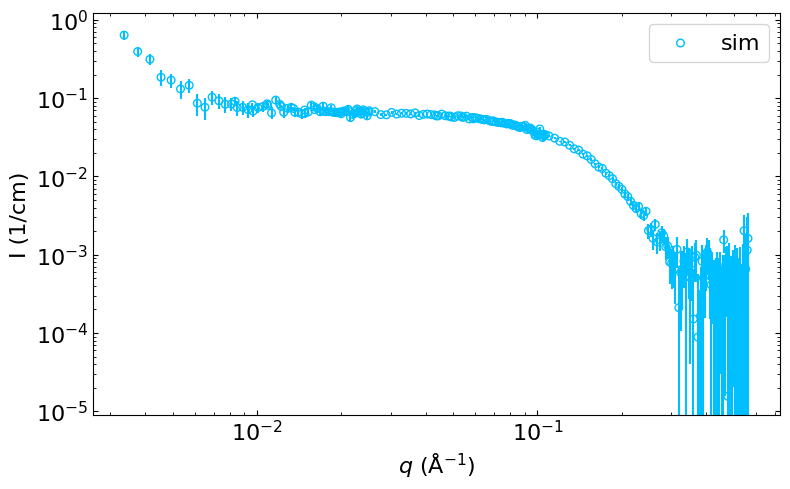

1/1 [==============================] - 0s 181ms/step

---Classification---
sphere 0.40
core_shell_sphere 0.03
ellipsoid 0.13
core_shell_ellipsoid 0.01
cylinder 0.21
core_shell_cylinder 0.01
three_pearl_necklace 0.16
lamellar 0.02
lamellar_hg 0.04

---Regression---
Model:  sphere
radius 15.049351
sld 0.11040148

Model:  core_shell_sphere
radius 21.836824
sld_core 0.5457011
sld_shell 0.06386438
thickness 17.393856

Model:  ellipsoid
radius_equatorial 16.61023
radius_polar 14.169434
sld 0.51631975

Model:  core_shell_ellipsoid
radius_equat_core 34.579185
sld_core 0.09350769
sld_shell 0.22299013
thick_shell 16.859179
x_core 5.2800474
x_polar_shell 4.5724654

Model:  cylinder
length 31.414362
radius 15.53861
sld -0.15386802

Model:  core_shell_cylinder
length 32.960976
radius 13.999569
sld_core -0.6497296
sld_shell 0.19225337
thickness 22.536512

Model:  three_pearl_necklace
edge_sep 553.0965
radius 14.9957485
sld -0.80351067
sld_string -0.1869805
thick_string 12.827204

Model:  lamellar
sl

In [4]:
predict('validation_exps/5LysNaCl.sub', ml_model)

validation_exps/DMPC_D2O.ABS

            Q          I         dI        dQ        c1  c2
0    0.001418  217.90000  14.620000  0.000233  0.001436   1
1    0.001676  227.90000  12.000000  0.000236  0.001691   1
2    0.001934  222.10000  10.500000  0.000240  0.001947   1
3    0.002192  224.60000  10.280000  0.000245  0.002203   1
4    0.002450  225.00000  10.860000  0.000250  0.002460   1
..        ...        ...        ...       ...       ...  ..
221  0.481500    0.06010   0.001253  0.023250  0.481500   1
222  0.485600    0.06372   0.001201  0.023440  0.485700   1
223  0.489700    0.06496   0.001205  0.023620  0.489800   1
224  0.493800    0.06432   0.001262  0.023810  0.493900   1
225  0.497900    0.06209   0.001326  0.023990  0.497900   1

[226 rows x 6 columns]


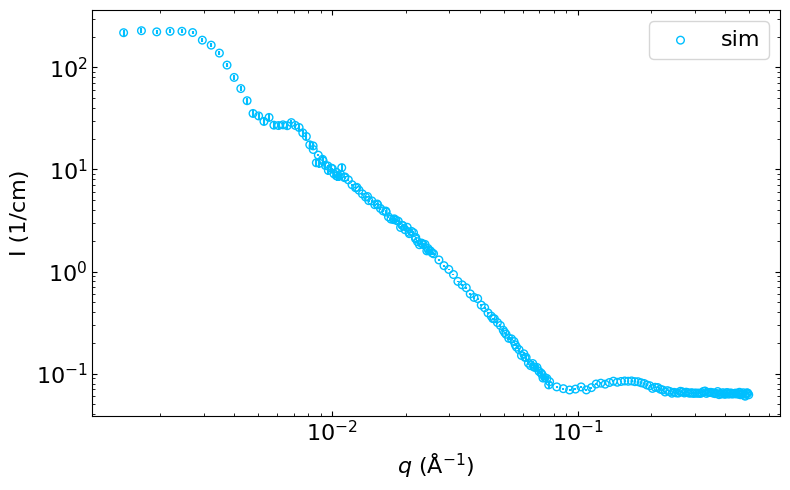

1/1 [==============================] - 0s 11ms/step

---Classification---
sphere 0.00
core_shell_sphere 0.02
ellipsoid 0.00
core_shell_ellipsoid 0.25
cylinder 0.05
core_shell_cylinder 0.21
three_pearl_necklace 0.00
lamellar 0.44
lamellar_hg 0.03

---Regression---
Model:  sphere
radius 146.93832
sld -0.106797844

Model:  core_shell_sphere
radius 79.41558
sld_core 0.19173951
sld_shell -0.18344185
thickness 102.89085

Model:  ellipsoid
radius_equatorial 104.24344
radius_polar 203.40851
sld -0.3848811

Model:  core_shell_ellipsoid
radius_equat_core 42.312862
sld_core -0.2940278
sld_shell 0.15486851
thick_shell 103.50895
x_core 4.986847
x_polar_shell 5.41341

Model:  cylinder
length 143.82452
radius 172.11172
sld 0.31985915

Model:  core_shell_cylinder
length 194.1902
radius 35.47039
sld_core -0.38046306
sld_shell -1.1737565
thickness 151.06256

Model:  three_pearl_necklace
edge_sep 378.3381
radius 124.374054
sld -0.2021254
sld_string -0.13231184
thick_string 12.19447

Model:  lamellar
sld 

In [5]:
predict('validation_exps/DMPC_D2O.ABS', ml_model, background=0.62)

validation_exps/DMPC_H2O.ABS

            Q         I         dI        dQ        c1  c2
0    0.001418  2349.000  62.740000  0.000233  0.001436   1
1    0.001676  2363.000  53.400000  0.000236  0.001691   1
2    0.001934  2409.000  62.220000  0.000240  0.001947   1
3    0.002192  2288.000  54.990000  0.000245  0.002203   1
4    0.002450  2150.000  46.670000  0.000250  0.002460   1
..        ...       ...        ...       ...       ...  ..
222  0.481500     1.089   0.008626  0.023250  0.481500   1
223  0.485600     1.091   0.006889  0.023440  0.485700   1
224  0.489700     1.082   0.008576  0.023620  0.489800   1
225  0.493800     1.094   0.007891  0.023810  0.493900   1
226  0.497900     1.094   0.007157  0.023990  0.497900   1

[227 rows x 6 columns]


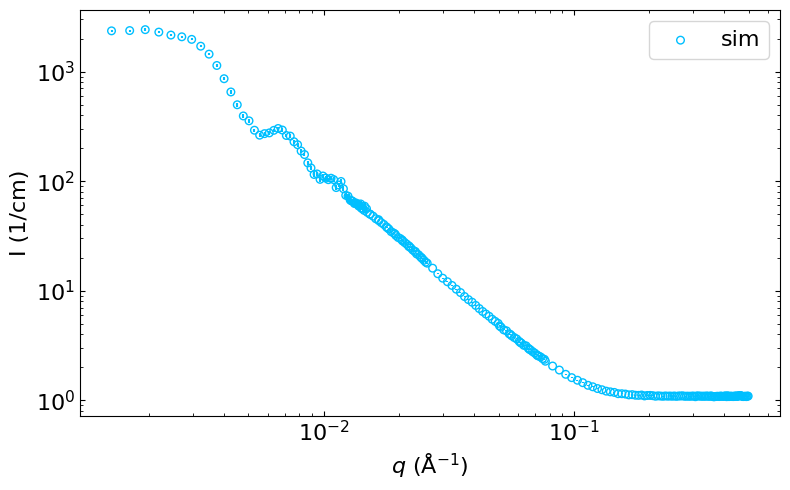

1/1 [==============================] - 0s 11ms/step

---Classification---
sphere 0.00
core_shell_sphere 0.00
ellipsoid 0.00
core_shell_ellipsoid 0.00
cylinder 0.00
core_shell_cylinder 0.00
three_pearl_necklace 0.00
lamellar 0.29
lamellar_hg 0.71

---Regression---
Model:  sphere
radius 93.33663
sld -0.105188385

Model:  core_shell_sphere
radius 88.938095
sld_core 0.23045214
sld_shell -0.08481738
thickness 118.26215

Model:  ellipsoid
radius_equatorial 190.76352
radius_polar 19.283855
sld -0.082990736

Model:  core_shell_ellipsoid
radius_equat_core 145.9531
sld_core -0.46429712
sld_shell -0.10618785
thick_shell 13.36167
x_core 5.4594193
x_polar_shell 4.447236

Model:  cylinder
length 29.921696
radius 184.8085
sld -0.5071263

Model:  core_shell_cylinder
length 31.645596
radius 179.44308
sld_core -0.2451193
sld_shell -0.28318152
thickness 24.158125

Model:  three_pearl_necklace
edge_sep 275.02014
radius 22.700043
sld -0.49115464
sld_string -0.36802423
thick_string 11.737869

Model:  lamell

In [6]:
predict('validation_exps/DMPC_H2O.ABS', ml_model, background=1.02)

validation_exps/CMSA5.ABS

            Q        I        dI        dQ        c1      c2
0    0.003069  1.77100  0.250500  0.001078  0.003434  0.4038
1    0.003478  2.27700  0.190100  0.001089  0.003655  0.9565
2    0.003888  2.89100  0.142700  0.001093  0.004030  0.9999
3    0.004297  2.76200  0.114100  0.001095  0.004425  1.0000
4    0.004706  2.56000  0.089910  0.001097  0.004823  1.0000
..        ...      ...       ...       ...       ...     ...
246  0.556800  0.05061  0.001298  0.031360  0.556800  1.0000
247  0.560500  0.04926  0.000943  0.031570  0.560500  1.0000
248  0.564300  0.04799  0.001374  0.031770  0.564300  1.0000
249  0.568000  0.04918  0.001354  0.031970  0.568000  1.0000
250  0.571700  0.04681  0.001814  0.032170  0.571700  1.0000

[251 rows x 6 columns]


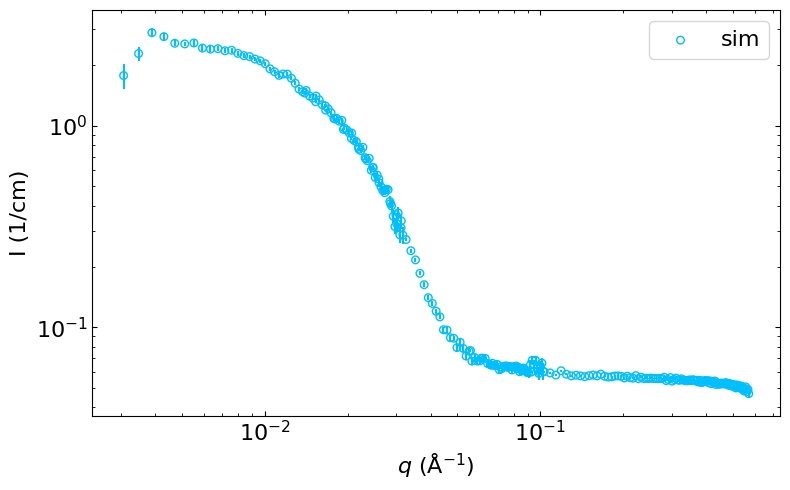

1/1 [==============================] - 0s 12ms/step

---Classification---
sphere 0.00
core_shell_sphere 0.00
ellipsoid 0.04
core_shell_ellipsoid 0.06
cylinder 0.15
core_shell_cylinder 0.74
three_pearl_necklace 0.00
lamellar 0.00
lamellar_hg 0.00

---Regression---
Model:  sphere
radius 104.097145
sld -0.12942068

Model:  core_shell_sphere
radius 87.10356
sld_core -0.24093638
sld_shell 0.08915645
thickness 122.386116

Model:  ellipsoid
radius_equatorial 72.97617
radius_polar 166.96033
sld -0.23044357

Model:  core_shell_ellipsoid
radius_equat_core 44.615665
sld_core -0.5685122
sld_shell -0.37744895
thick_shell 28.04298
x_core 5.7300572
x_polar_shell 5.1315217

Model:  cylinder
length 61.657898
radius 105.67755
sld -0.5433042

Model:  core_shell_cylinder
length 164.56688
radius 45.863457
sld_core -0.6872118
sld_shell -1.1490357
thickness 33.79621

Model:  three_pearl_necklace
edge_sep 472.0765
radius 71.43999
sld -0.40917942
sld_string -0.27998787
thick_string 12.451929

Model:  lamellar


In [7]:
predict('validation_exps/CMSA5.ABS', ml_model, background=0.047)